<a href="https://colab.research.google.com/github/zhuohann/SP500PerfromancePredictionWithSentimentAnalysis/blob/master/S%26P_daily_direction_prediction_with_sentiment_analysis(Pandas).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install vaderSentiment
!pip install tf-nightly-2.0-preview
!pip install textblob
import csv
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tensorflow as tf
import numpy
from numpy import array
import pandas as pd
from tensorflow.keras.optimizers import RMSprop, Ftrl, Adagrad, SGD, Adadelta, Adam, Adamax, Nadam
print(tf.__version__)
analyser = SentimentIntensityAnalyzer()

2.0.0-dev20191002


In [0]:
SPIndex = pd.read_csv("/tmp/SPIndex.csv")
NewsCSV = pd.read_csv("/tmp/news.csv")


In [0]:
dataset_SP_Sentiment = pd.DataFrame(SPIndex,columns= ['Date','open','close'])
dataset_SP_Sentiment["close-open"] = dataset_SP_Sentiment["close"]-dataset_SP_Sentiment["open"]
dataset_SP_Sentiment['Date'] = pd.to_datetime(dataset_SP_Sentiment.Date)
#dataset_SP_Sentiment.head()

In [0]:
NewsCSV["Date"] = pd.to_datetime(NewsCSV.Date)
NewsCSV = NewsCSV.drop(columns = "Label")
#NewsCSV.head()

In [0]:
dataset_SP_Sentiment = pd.merge(left=dataset_SP_Sentiment,right=NewsCSV)
dataset_SP_Sentiment = dataset_SP_Sentiment.drop(columns = ["Top21","Top22","Top23","Top24","Top25"])
#dataset_SP_Sentiment.head()


In [0]:
sentimentscore = pd.DataFrame()
sentimentscore_textblob = pd.DataFrame()
for i in range(20):
  ColumnName = "Top"+str(int(i+1))
  sentimentscore[ColumnName] = dataset_SP_Sentiment[ColumnName].apply(lambda x : analyser.polarity_scores(x[2:-1])['compound'])
  sentimentscore_textblob[ColumnName] = dataset_SP_Sentiment[ColumnName].apply(lambda x : TextBlob(x[2:-1]).sentiment.polarity)

In [8]:
sentimentscore.head()

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20
0,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,-0.5994,-0.6486,-0.2263,-0.7645,0.0000,-0.5994,-0.5994,0.0000,0.2086,0.2023,0.0258
1,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.3578,-0.3400,0.0000,0.7783,0.0000,-0.3818,-0.1027,-0.2960,-0.3804,-0.8271,0.0000,-0.5994
2,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,-0.7650,-0.7964,-0.4404,-0.8591,0.0000,0.5423,0.0000,0.0000,0.0772,-0.5994,-0.5859
3,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.5106,0.0000,0.3612,0.4574,0.4019,-0.2263,-0.2500,-0.2960,0.0000,0.0000,0.0000,0.0000,-0.5423,-0.0258
4,0.2023,-0.5994,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,-0.3400,0.0000,0.0000,0.0000,0.1779,0.0000,-0.6249,0.0000,-0.7579,-0.3182,0.0000


In [9]:
sentimentscore_textblob.head()

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20
0,0.0,0.000000,0.00,0.050000,-0.307143,-0.051852,0.000,-0.200000,-0.100,0.0,0.033333,0.033333,-0.033333,-0.125000,0.000000,0.35,0.000000,-0.100000,0.078788,0.000000
1,0.0,-0.155556,0.10,0.000000,0.000000,0.136364,-0.425,0.250000,0.600,0.0,0.000000,0.183333,0.000000,0.136364,0.000000,-0.40,0.250000,0.000000,0.000000,0.000000
2,0.0,0.000000,-0.25,-0.875000,0.000000,0.000000,0.000,0.022222,-0.025,0.0,0.038095,-0.150000,0.000000,0.214286,0.500000,0.25,0.285714,-0.333333,-0.600000,0.000000
3,0.0,0.000000,-0.20,-0.212963,0.175000,0.000000,0.000,0.000000,0.000,0.5,-0.166667,0.000000,0.133333,0.000000,0.285714,-0.40,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.40,-0.233333,-0.200000,-0.500000,0.625,0.166667,0.000,-0.1,0.000000,0.285714,0.000000,0.550000,-0.025000,0.10,0.000000,0.066667,0.000000,0.068182


Text(0.5, 1, 'Correlation heat map for vadersentiment scores')

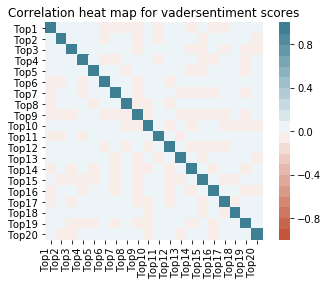

In [10]:
corr = sentimentscore.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
ax.set_title("Correlation heat map for vadersentiment scores")

Text(0.5, 1, 'Correlation heat map for TextBlob sentiment scores')

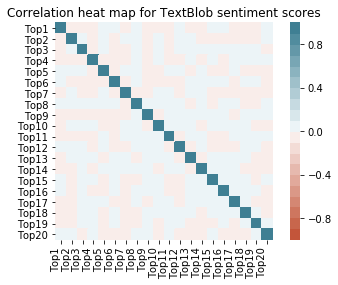

In [11]:
corr = sentimentscore_textblob.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
ax.set_title("Correlation heat map for TextBlob sentiment scores")

In [0]:
dataset_SP_Sentiment['Up or Down'] = dataset_SP_Sentiment['close-open'].apply(lambda x : 1 if (x > 0) else 0)
#dataset_SP_Sentiment.head()

In [0]:
x_train = sentimentscore[0:1300]
y_train = dataset_SP_Sentiment['Up or Down'][1:1301]
x_valid = sentimentscore[1300:1310]
y_valid = dataset_SP_Sentiment['Up or Down'][1301:1311]

x_train2 = sentimentscore_textblob[0:1300]
x_valid2 = sentimentscore_textblob[1300:1310]

In [0]:
features = ["Top1","Top2","Top3","Top4","Top5","Top6","Top7","Top8","Top9","Top10","Top11","Top12","Top13","Top14","Top15","Top16","Top17","Top18","Top19","Top20"]

train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_train.values, tf.float32), tf.cast(y_train.values, tf.int32))).batch(5)
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_valid.values, tf.float32), tf.cast(y_valid.values, tf.int32))).batch(5)
train_dataset2 = tf.data.Dataset.from_tensor_slices((tf.cast(x_train2.values, tf.float32), tf.cast(y_train.values, tf.int32))).batch(5)
valid_dataset2 = tf.data.Dataset.from_tensor_slices((tf.cast(x_valid2.values, tf.float32), tf.cast(y_valid.values, tf.int32))).batch(5)
#valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_valid[features].values, tf.float32), tf.cast(y_valid.values, tf.int32))).batch(5)

In [0]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1, activation= "sigmoid")
])

model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-5),metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy',optimizer= Adagrad(lr = 5e-4),metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy',optimizer= SGD(lr = 5e-4),metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy',optimizer= Adadelta(lr = 1e-3),metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy',optimizer= Adam(lr=1e-3),metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy',optimizer= Adamax(lr=5e-3),metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy',optimizer= Nadam(lr=1e-4),metrics=['binary_accuracy'])
history = model.fit(train_dataset,validation_data = valid_dataset,epochs=500,verbose=0)

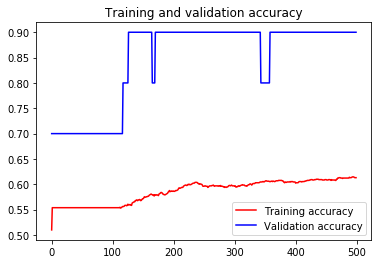

<Figure size 432x288 with 0 Axes>

In [35]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

startpoint = 0
epochs = range(len(acc))

plt.plot(epochs[startpoint:], acc[startpoint:], 'r', label='Training accuracy')
plt.plot(epochs[startpoint:], val_acc[startpoint:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

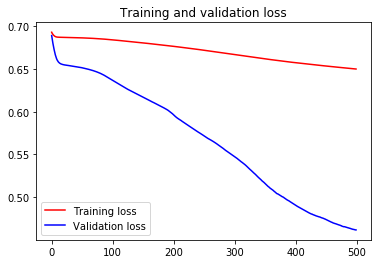

<Figure size 432x288 with 0 Axes>

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
startpoint = 0

plt.plot(epochs[startpoint:], loss[startpoint:], 'r', label='Training loss')
plt.plot(epochs[startpoint:], val_loss[startpoint:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [37]:
prediction  = model.predict(tf.cast(sentimentscore[1300:1320].values, tf.float32)).round().flatten()
prediction.astype(int)
actual = dataset_SP_Sentiment['Up or Down'][1301:1321].values
for x,y in zip(actual,prediction):
  print("Actual: {}    Prediction: {}".format(x,y))

Actual: 0    Prediction: 0.0
Actual: 1    Prediction: 1.0
Actual: 1    Prediction: 1.0
Actual: 1    Prediction: 1.0
Actual: 0    Prediction: 0.0
Actual: 1    Prediction: 1.0
Actual: 1    Prediction: 1.0
Actual: 1    Prediction: 0.0
Actual: 0    Prediction: 0.0
Actual: 1    Prediction: 1.0
Actual: 0    Prediction: 0.0
Actual: 1    Prediction: 1.0
Actual: 1    Prediction: 1.0
Actual: 1    Prediction: 1.0
Actual: 1    Prediction: 1.0
Actual: 0    Prediction: 0.0
Actual: 0    Prediction: 1.0
Actual: 1    Prediction: 0.0
Actual: 1    Prediction: 1.0
Actual: 0    Prediction: 0.0
